In [60]:
import numpy as np 
import jVMC
import jax.numpy as jnp
import jax.random as jrnd
import matplotlib.pyplot as plt
from tqdm import tqdm


In [61]:
s  = jnp.zeros(5,dtype=int)+1
y = jnp.pad(s[:-1],(1,0),mode='constant',constant_values=0)
y

Array([0, 1, 1, 1, 1], dtype=int64)

In [62]:
N = 10
L = 10
ldim = 11
homFock = jnp.ones((1,1,L),dtype=int)
oneSiteFockStates = jnp.expand_dims(jnp.eye(L,dtype=int)*N,0)
J = 1.
U = 0.
H = jVMC.operator.bosons.BoseHubbard_Hamiltonian1D(L,J,U,lDim=ldim)

depth_RWKV = 4
emb_RWKV =16
hidden_size=32
num_heads = 2

ebDim = 16
dep = 3
nH = 4

#net = jVMC.nets.RpxRWKV(L,LocalHilDim=ldim,hidden_size=hidden_size,num_heads=num_heads,embedding_size=emb_RWKV,num_layers=depth_RWKV,)
net = jVMC.nets.bosons.gpt_stupid.GPT(L,ldim,embeddingDim=ebDim,depth=dep,nHeads=nH)
seed = 252
key2 = jrnd.PRNGKey(seed)
numSamp = 2**8



In [63]:
net.__name__, #net2.__name__
psi_net= jVMC.vqs.NQS(net,seed=seed)
print(psi_net(homFock))
pa = psi_net.get_parameters()
print(pa.size)
sampler_net = jVMC.sampler.MCSampler(psi_net,(L,),key2)


[[-45.83554724]]
10011


In [64]:
sampler_net.sample(numSamples=3)

(Array([[[3, 8, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 9, 3, 3, 3, 3, 3, 3, 3, 3],
         [8, 9, 3, 3, 3, 3, 3, 3, 3, 3]]], dtype=int64),
 Array([[-0.97642625, -0.61009394, -3.52092168]], dtype=float64),
 Array([[0.33333333, 0.33333333, 0.33333333]], dtype=float64))

In [65]:
gum_net = jVMC.nets.gumbel_wrapper(net)
psi_gum_net= jVMC.vqs.NQS(gum_net,seed=seed)
print(psi_gum_net(homFock))
psi_gum_net.set_parameters(pa)
print(psi_gum_net(homFock))


[[-42.46985621]]
[[-45.83554724]]


In [66]:

sampler_gum_net = jVMC.sampler.MCSampler(psi_gum_net,(L,),key2)

s,logpsi,p = sampler_gum_net.sample(numSamples=1)
logpsi/ psi_gum_net(s)

Array([[1.]], dtype=float64)

In [67]:
logpsi, psi_gum_net(s),psi_net(s)

(Array([[-3.07876062]], dtype=float64),
 Array([[-3.07876062]], dtype=float64),
 Array([[-3.07876062]], dtype=float64))

In [68]:

sym= jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")
sym_net = jVMC.nets.sym_wrapper.SymNet(sym,net,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)
gum_net = jVMC.nets.gumbel_wrapper(net)
par_net = jVMC.nets.particle_conservation(net,N)

psi_sym_net= jVMC.vqs.NQS(sym_net,seed=seed)
psi_gum_net= jVMC.vqs.NQS(gum_net,seed=seed)
psi_par_net= jVMC.vqs.NQS(par_net,seed=seed)

psi_sym_net(homFock)
psi_gum_net(homFock)
psi_par_net(homFock)


Array([[-30.95026829]], dtype=float64)

In [69]:
sampler_sym_net = jVMC.sampler.MCSampler(psi_sym_net,(L,),key2)
sampler_gum_net = jVMC.sampler.MCSampler(psi_gum_net,(L,),key2)
sampler_par_net = jVMC.sampler.MCSampler(psi_par_net,(L,),key2)


sampler_sym_net.sample(numSamples=numSamp),
sampler_gum_net.sample(numSamples=numSamp),
sampler_par_net.sample(numSamples=10)

(Array([[[ 6,  0,  3,  0,  0,  0,  0,  0,  0,  1],
         [ 6,  0,  2,  0,  2,  0,  0,  0,  0,  0],
         [10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 7,  0,  3,  0,  0,  0,  0,  0,  0,  0],
         [10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 6,  2,  0,  0,  2,  0,  0,  0,  0,  0]]], dtype=int64),
 Array([[-2.82476921, -2.29782024, -0.47362055, -0.47362055, -0.47362055,
         -0.47362055, -1.86106239, -0.47362055, -0.47362055, -2.59170687]],      dtype=float64),
 Array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float64))

In [70]:

sym_par_net = jVMC.nets.sym_wrapper.SymNet(sym,par_net,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)
gum_par_net = jVMC.nets.gumbel_wrapper(par_net)
sym_gum_net = jVMC.nets.sym_wrapper.SymNet(sym,gum_net,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)

psi_sym_par_net= jVMC.vqs.NQS(sym_par_net,seed=1)
psi_gum_par_net= jVMC.vqs.NQS(gum_par_net,seed=1)
psi_sym_gum_net= jVMC.vqs.NQS(sym_gum_net,seed=1)

#psi_sym_par_net(homFock),psi_gum_par_net(homFock),psi_sym_gum_net(homFock)


In [71]:
type(gum_par_net.net) == "particle_conservation"

False

In [72]:
sampler_sym_par_net = jVMC.sampler.MCSampler(psi_sym_par_net,(L,),key2)
sampler_gum_par_net = jVMC.sampler.MCSampler(psi_gum_par_net,(L,),key2)
sampler_sym_gum_net = jVMC.sampler.MCSampler(psi_sym_gum_net,(L,),key2)


sampler_sym_par_net.sample(numSamples=numSamp),sampler_gum_par_net.sample(numSamples=numSamp),sampler_sym_gum_net.sample(numSamples=numSamp)


((Array([[[1, 1, 4, ..., 0, 0, 0],
          [4, 4, 1, ..., 0, 0, 0],
          [0, 1, 1, ..., 0, 0, 0],
          ...,
          [1, 1, 0, ..., 0, 4, 4],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 1, 1, ..., 0, 0, 0]]], dtype=int64),
  Array([[-1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
          -1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
          -1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
          -1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
          -1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
          -1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
          -1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
          -1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
          -1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
          -1.50497842, -1.50497842, -1.50497842, -1.50497842, -1.50497842,
         

In [73]:
sampler_gum_par_net.sample(numSamples=10)

(Array([[[4, 4, 1, 1, 0, 0, 0, 0, 0, 0],
         [4, 4, 2, 0, 0, 0, 0, 0, 0, 0],
         [4, 1, 4, 1, 0, 0, 0, 0, 0, 0],
         [4, 4, 0, 1, 1, 0, 0, 0, 0, 0],
         [4, 4, 1, 0, 1, 0, 0, 0, 0, 0],
         [1, 4, 4, 1, 0, 0, 0, 0, 0, 0],
         [4, 2, 4, 0, 0, 0, 0, 0, 0, 0],
         [4, 1, 4, 0, 1, 0, 0, 0, 0, 0],
         [2, 4, 4, 0, 0, 0, 0, 0, 0, 0],
         [8, 1, 1, 0, 0, 0, 0, 0, 0, 0]]], dtype=int64),
 Array([[-0.00711275, -2.37556997, -2.97921142, -3.43179944, -3.27988161,
         -4.26848871, -4.43913126, -5.85615869, -6.2449576 , -6.36276155]],      dtype=float64),
 Array([[9.85961187e-01, 8.64259217e-03, 2.58420950e-03, 1.04523696e-03,
         1.41634453e-03, 1.96099141e-04, 1.39398292e-04, 8.19300220e-06,
         3.76475418e-06, 2.97449618e-06]], dtype=float64))

In [74]:
sym_gum_par_net = jVMC.nets.sym_wrapper.SymNet(sym,gum_par_net,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)

psi_sym_gum_par_net= jVMC.vqs.NQS(sym_gum_par_net,seed=1)

psi_sym_par_net(homFock)

Array([[-12.03995602]], dtype=float64)

In [75]:
sampler_sym_gum_par_net = jVMC.sampler.MCSampler(psi_sym_gum_par_net,(L,),key2)

sampler_sym_gum_par_net.sample(numSamples=numSamp)

(Array([[[1, 2, 4, ..., 0, 0, 0],
         [3, 4, 3, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 2, 1, ..., 0, 3, 2],
         [0, 0, 0, ..., 0, 1, 0],
         [0, 0, 2, ..., 0, 0, 0]]], dtype=int64),
 Array([[-2.61381874, -2.43024908, -2.84625375, -2.72115759, -2.54654548,
         -3.14277552, -3.51649553, -4.70523175, -3.0519353 , -3.04438074,
         -5.01070204, -3.69438294, -4.21794689, -3.594182  , -2.50492785,
         -3.95410975, -4.0992758 , -4.22968371, -4.8755758 , -4.56595364,
         -3.65278819, -4.88227347, -4.0992758 , -5.99535562, -4.46148386,
         -3.26610061, -5.03645544, -4.4327132 , -5.38827028, -5.19881745,
         -4.69758467, -3.33797184, -5.70244843, -4.4265629 , -4.33597962,
         -2.72115759, -4.45679591, -4.49974988, -3.91569815, -3.78416796,
         -4.19884287, -3.81488132, -5.48876391, -4.29569098, -2.72115759,
         -2.50492785, -2.84625375, -5.24340076, -3.87828828, -4.88227347,
         -4.28534346, -5.4

In [105]:
key = jrnd.PRNGKey(1)
key2 = jrnd.PRNGKey(1)

sampler = sampler_sym_par_net
psi = psi_sym_par_net
lr_SR = 1e-2
sampler.numSamples = 2**8
minSR_equation = jVMC.util.MinSR(sampler, makeReal='real',diagonalShift=0,diagonalMulti=0)
stepperSR = jVMC.util.stepper.Euler(timeStep=lr_SR)  
renormalisation = None # 0.1

In [106]:
training_steps= 300
resTraining = np.zeros((training_steps,2))
resTraining_gumbel = np.zeros((training_steps,2))


pbar = tqdm(range(training_steps))
for n,p in enumerate(pbar):
    
    dpOld = psi.get_parameters()        
    
    #print(dpOld)
    #dpOld = psi.get_parameters()            
    n_p = jnp.linalg.norm(dpOld)
    dp    = minSR_equation(dpOld,0,hamiltonian=H, psi=psi,intStep=0)
    dp = jnp.nan_to_num(dp,0.)
    #for i in range(repeats):
    #    dp_add  = equations(dpOld,0,hamiltonian=H, psi=psi,intStep=0)
    #    dp += jnp.nan_to_num(dp_add,0.)
    #dp /= repeats
    n_grad = jnp.linalg.norm(dp)

    if renormalisation is not None:
        dp = renormalisation *dp/n_grad
    
    #dp, _ = stepperSR.step(0, equations, dpOld, hamiltonian=H, psi=psi)
    psi.set_parameters(dpOld + lr_SR * jnp.real(dp))
    resTraining[n] = [jnp.real(minSR_equation.ElocMean0) , minSR_equation.ElocVar0 ]
    #print(dp)
    
    pbar.set_description(f"energy: {resTraining[n][0]:.4f}+-{np.sqrt(resTraining[n][1]):.4f}")
    


energy: -20.0004+-0.0048: 100%|██████████| 300/300 [02:27<00:00,  2.03it/s]


In [100]:
net

GPT(
    # attributes
    L = 10
    LocalHilDim = 11
    embeddingDim = 16
    depth = 3
    nHeads = 4
    logProbFactor = 0.5
    paramDType = float64
    spinDType = int64
    __name__ = 'GPT'
)

(10, 10)

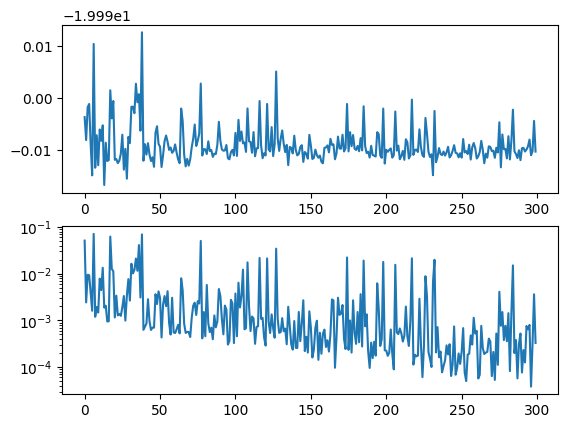

In [104]:

fig, ax = plt.subplots(2)
ax[0].plot(resTraining[:,0])
ax[1].semilogy(resTraining[:,1])
N,L

In [80]:
observalbes_dict = {
                    "H": [H], 
                    }
out_dict = jVMC.util.util.measure(observalbes_dict, psi_sym_gum_par_net, sampler_sym_gum_par_net)

In [81]:
out_dict["H"]["mean"]

Array([-11.62461242], dtype=float64)

In [82]:
s, log_psi, psi_p = sampler_gum_par_net.sample()

In [83]:
psi_p.sum(-1)

Array([1.], dtype=float64)

In [84]:
s, log_psi, psi_p = sampler_gum_par_net.sample()

In [85]:
matel = H.get_O_loc(s,psi_gum_par_net,log_psi,0.)

In [86]:
sum(matel.flatten() * psi_p.flatten())

Array(-0.35685498+0.j, dtype=complex128)

In [87]:
s, log_psi, psi_p = sampler_gum_net.sample()
log_psi-psi_gum_net(s),log_psi[0,:10],psi_gum_net(s)[0,:10]

(Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float64),
 Array([-5.16340634, -6.58116142, -1.38538071, -3.38478364, -5.22546816,
        -6.41196689, -2.66342154, -3.11909972, -1.60370538, -6.3731284 ],      dtype=float64),
 Array([-5.16340634, -6.58116142, -1.38538071, -3.38478364, -5.22546816,
        -6.41196689, -2.66342154, -3.11909972, -1.60370538, -6.3731284 ],      dtype=float64))

In [88]:
s, log_psi, psi_p = sampler_par_net.sample()
log_psi-psi_par_net(s)

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float64)

In [89]:
s, log_psi, psi_p = sampler_sym_par_net.sample()
log_psi-psi_sym_par_net(s)

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [90]:
s, log_psi, psi_p = sampler_gum_par_net.sample()
log_psi-psi_gum_par_net(s),jnp.linalg.norm(log_psi-psi_gum_par_net(s))

(Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float64),
 Array(0., dtype=float64))

In [91]:

s, log_psi, psi_p = sampler_sym_gum_par_net.sample()
log_psi-psi_sym_gum_par_net(s),jnp.linalg.norm(log_psi-psi_sym_gum_par_net(s))


(Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float64),
 Array(0., dtype=float64))

In [92]:

psi_sym_gum_par_net(s),log_psi


(Array([[-3.69438294, -2.72115759, -2.50492785, -2.84625375, -2.54654548,
         -2.61381874, -3.91569815, -3.65278819, -2.84625375, -3.51649553,
         -3.0519353 , -3.26610061, -5.03645544, -4.46148386, -3.14277552,
         -4.28534346, -6.0495446 , -3.04438074, -2.43024908, -4.56595364,
         -4.49974988, -4.19884287, -2.72115759, -4.54141364, -4.40888362,
         -4.16338468, -4.0992758 , -4.29569098, -4.21794689, -3.81488132,
         -4.61106874, -4.99433433, -4.74486451, -3.33797184, -3.87828828,
         -5.23296116, -3.594182  , -4.582927  , -2.50492785, -4.46148386,
         -2.50492785, -4.22968371, -5.10357126, -4.50466193, -5.88679541,
         -5.19799158, -4.76695404, -4.83545085, -3.95410975, -4.71076209,
         -4.45958589, -4.15305597, -6.47764536, -4.70523175, -4.29584865,
         -5.99535562, -4.31983124, -4.68448048, -5.31896609, -3.78416796,
         -5.01986064, -4.24398525, -4.4265629 , -4.88285453, -4.19884287,
         -2.54654548, -2.61381874, -5.

In [93]:

s, log_psi, psi_p = sampler_sym_gum_net.sample()
log_psi-psi_sym_gum_net(s),jnp.linalg.norm(log_psi-psi_sym_gum_net(s))



(Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float64),
 Array(0., dtype=float64))

In [94]:
s, log_psi,

(Array([[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
         [4, 4, 1, 4, 4, 4, 4, 4, 4, 4],
         [4, 4, 4, 4, 1, 1, 1, 4, 8, 4],
         [4, 4, 4, 4, 1, 4, 1, 4, 4, 4],
         [8, 1, 4, 1, 1, 4, 4, 4, 4, 4],
         [4, 1, 1, 1, 4, 4, 4, 4, 4, 4],
         [4, 1, 1, 4, 4, 4, 4, 4, 4, 4],
         [4, 4, 4, 4, 4, 8, 1, 1, 4, 4],
         [1, 1, 4, 4, 4, 4, 4, 4, 4, 4],
         [4, 1, 4, 4, 1, 1, 4, 4, 4, 4],
         [4, 4, 4, 4, 1, 4, 1, 8, 1, 4],
         [4, 4, 4, 4, 4, 4, 4, 4, 4, 1],
         [4, 4, 1, 8, 1, 4, 4, 4, 4, 4],
         [4, 4, 1, 4, 1, 1, 1, 4, 4, 4],
         [4, 4, 8, 4, 4, 4, 1, 1, 4, 4],
         [4, 4, 4, 4, 4, 4, 4, 4, 4, 1],
         [4, 4, 4, 1, 4, 1, 8, 4, 4, 4],
         [1, 1, 4, 4, 4, 4, 4, 4, 4, 1],
         [4, 4, 4, 4, 1, 4, 4, 4, 4, 4],
         [4, 1, 1, 4, 4, 4, 4, 4, 4, 1],
         [4, 4, 4, 4, 4, 4, 8, 4, 1, 4],
         [4, 4, 4, 4, 4, 4, 8, 1, 4, 4],
         [4, 4, 4, 4, 1, 1, 1, 1, 4, 4],
         [4, 4, 4, 4, 4, 4, 8, 4, 4, 4],
         [4, 4, 

In [95]:
s, log_psi, psi_p = sampler_gum_net.sample()
log_psi-psi_gum_net(s),jnp.linalg.norm(log_psi-psi_gum_net(s))

(Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float64),
 Array(0., dtype=float64))

In [96]:
s, log_psi, psi_p = sampler_gum_par_net.sample()
log_psi,psi_gum_par_net(s),jnp.linalg.norm(log_psi-psi_gum_par_net(s))

(Array([[-7.11275113e-03, -2.37556997e+00, -3.27988161e+00,
         -2.97921142e+00, -5.85615869e+00, -3.43179944e+00,
         -5.25396706e+00, -4.43913126e+00, -4.26848871e+00,
         -6.33596244e+00, -6.43464288e+00, -5.76830983e+00,
         -7.10450149e+00, -6.53441376e+00, -5.59497835e+00,
         -7.77801530e+00, -6.36276155e+00, -5.88910763e+00,
         -6.98089426e+00, -7.62463279e+00, -6.64424748e+00,
         -7.49897197e+00, -5.81771387e+00, -8.75014762e+00,
         -7.71492338e+00, -7.59558079e+00, -6.86222210e+00,
         -6.24495760e+00, -6.57748208e+00, -8.70573321e+00,
         -7.63200305e+00, -7.03595611e+00, -7.68013722e+00,
         -7.57724838e+00, -8.98079886e+00, -7.90644044e+00,
         -7.25775188e+00, -7.67584574e+00, -8.77163403e+00,
         -7.76984665e+00, -1.00220012e+01, -8.25985357e+00,
         -8.75413436e+00, -8.78521981e+00, -8.35137837e+00,
         -8.91970175e+00, -8.04943737e+00, -8.91412925e+00,
         -8.68667095e+00, -8.08095206e+0

In [97]:
psi_gum_par_net(s)

Array([[-7.11275113e-03, -2.37556997e+00, -3.27988161e+00,
        -2.97921142e+00, -5.85615869e+00, -3.43179944e+00,
        -5.25396706e+00, -4.43913126e+00, -4.26848871e+00,
        -6.33596244e+00, -6.43464288e+00, -5.76830983e+00,
        -7.10450149e+00, -6.53441376e+00, -5.59497835e+00,
        -7.77801530e+00, -6.36276155e+00, -5.88910763e+00,
        -6.98089426e+00, -7.62463279e+00, -6.64424748e+00,
        -7.49897197e+00, -5.81771387e+00, -8.75014762e+00,
        -7.71492338e+00, -7.59558079e+00, -6.86222210e+00,
        -6.24495760e+00, -6.57748208e+00, -8.70573321e+00,
        -7.63200305e+00, -7.03595611e+00, -7.68013722e+00,
        -7.57724838e+00, -8.98079886e+00, -7.90644044e+00,
        -7.25775188e+00, -7.67584574e+00, -8.77163403e+00,
        -7.76984665e+00, -1.00220012e+01, -8.25985357e+00,
        -8.75413436e+00, -8.78521981e+00, -8.35137837e+00,
        -8.91970175e+00, -8.04943737e+00, -8.91412925e+00,
        -8.68667095e+00, -8.08095206e+00, -8.01263109e+0